<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/SML2020/06_regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実データの単回帰分析

## description vs prediction 

今回は、単回帰をpredictionにではなくdescriptionに使う。

* description＝与えられたデータを理解する

* prediction＝未知の入力について出力を求めたい（機械学習の主戦場）

* explanation＝因果関係の理解まで含む

https://www.slideshare.net/gshmueli/to-explain-to-predict-or-to-describe


# 今回参考にした本

Laura Igual, Santi Seguí.<br/>
Introduction to Data Science: A Python Approach to Concepts, Techniques and Applications. Springer. 2017.

https://link.springer.com/book/10.1007%2F978-3-319-50017-1

# 海氷域面積と気候変動
北半球と南半球の海氷域面積を分析し、面積が減少傾向にあるのかどうかを調べてみる。（上の本の6.2.1節より。）

データは、下記の場所から取得。

https://nsidc.org/data/seaice_index/archives


「data」タブをクリックし、以下の2つのファイルをダウンロードしておく。
*   [北極域の海氷域面積データ](ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv)
*   [南極域の海氷域面積データ](ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv)

<br/>
参考：半旬ごとにまとめたデータなら、気象庁の下記のページにある。

https://www.data.jma.go.jp/gmd/kaiyou/db/seaice/global/globe_area.html


### 1) データファイルを読み込んで前処理をする

In [0]:
import pandas as pd

In [0]:
# 北半球のデータを扱う（南半球のデータは自習）
n_ice = pd.read_csv('S_seaice_extent_daily_v3.0.csv')
print('shape:', n_ice.shape)
n_ice.head() 

shape: (13491, 6)


,Year,Month,Day,Extent,Missing,Source Data
0,YYYY,MM,DD,10^6 sq km,10^6 sq km,Source data product web sites: http://nsidc.o...
1,1978,10,26,17.624,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...
2,1978,10,28,17.803,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...
3,1978,10,30,17.670,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...
4,1978,11,01,17.527,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...


毎日のデータがあるわけではないことが分かる。

（例：1978年10月27日のデータはない。）

In [0]:
# 列名の文字列に空白がある
n_ice.columns

Index(['Year', ' Month', ' Day', '     Extent', '    Missing', ' Source Data'], dtype='object')

In [0]:
# 列名の空白を除去する
n_ice.columns = n_ice.columns.str.strip()
n_ice.columns

Index(['Year', 'Month', 'Day', 'Extent', 'Missing', 'Source Data'], dtype='object')

In [0]:
# 必要な列だけ残す
n_ice2 = n_ice[['Year', 'Month', 'Day', 'Extent']]

In [0]:
# 最初の行はデータのフォーマットの説明のようだ
n_ice2.head()

,Year,Month,Day,Extent
0,YYYY,MM,DD,10^6 sq km
1,1978,10,26,17.624
2,1978,10,28,17.803
3,1978,10,30,17.670
4,1978,11,01,17.527


In [0]:
# だから、最初の行は削除する
n_ice3 = n_ice2.iloc[1:,]
n_ice3.head()

,Year,Month,Day,Extent
1,1978,10,26,17.624
2,1978,10,28,17.803
3,1978,10,30,17.670
4,1978,11,01,17.527
5,1978,11,03,17.486


In [0]:
# 1978年と2020年はデータが完全でないので、削除する
n_ice4 = n_ice3.loc[(n_ice3['Year'] != '1978') & (n_ice3['Year'] != '2020'),]
n_ice4.head()

,Year,Month,Day,Extent
35,1979,01,02,6.945
36,1979,01,04,6.838
37,1979,01,06,6.638
38,1979,01,08,6.270
39,1979,01,10,6.138


In [0]:
n_ice4.tail()

,Year,Month,Day,Extent
13387,2019,12,27,6.904
13388,2019,12,28,6.804
13389,2019,12,29,6.659
13390,2019,12,30,6.499
13391,2019,12,31,6.338


In [0]:
# 数値化する（年月日は整数に。海氷域面積は浮動小数点数に。）
int_cols = ['Year', 'Month', 'Day']
cols_as_int = n_ice4[int_cols].astype(int)
col_as_float = n_ice4['Extent'].astype(float)
n_ice = pd.concat([cols_as_int, col_as_float], axis=1)
n_ice.head()

,Year,Month,Day,Extent
35,1979,1,2,6.945
36,1979,1,4,6.838
37,1979,1,6,6.638
38,1979,1,8,6.270
39,1979,1,10,6.138


In [0]:
# 行のindexを打ち直す
n_ice.reset_index(drop=True, inplace=True)
n_ice.head()

,Year,Month,Day,Extent
0,1979,1,2,6.945
1,1979,1,4,6.838
2,1979,1,6,6.638
3,1979,1,8,6.270
4,1979,1,10,6.138


In [0]:
# おかしな値がないかチェックする
# （欠測値が特殊な値で表されていたりするデータもあるため。）
n_ice.describe()['Extent']

count    13357.000000
mean        11.678608
std          5.635553
min          2.080000
25%          6.084000
50%         12.634000
75%         17.237000
max         20.201000
Name: Extent, dtype: float64

### 2) 一ヶ月ごとにデータをまとめて、平均をとる
これは、「同じ月の中での値の変動は、ノイズにすぎない」と、仮定していることに相当する。

もちろん、このように仮定するのが正しいかどうかは、分からない。

In [0]:
n_ice_grouped = n_ice.groupby(['Year', 'Month'], as_index=False)
n_ice_monthly = n_ice_grouped.mean()[['Year', 'Month', 'Extent']]
n_ice_monthly.head()

,Year,Month,Extent
0,1979,1,5.402200
1,1979,2,3.141071
2,1979,3,3.999312
3,1979,4,7.485533
4,1979,5,10.826667


In [0]:
# 変数名を付け直す
n_ice = n_ice_monthly

In [0]:
# 可視化の準備
import numpy as np
import matplotlib.pylab as plt

横軸は年にし、同じ年のデータは縦方向にまとめてプロットしてみる。

Text(0, 0.5, 'Extent')

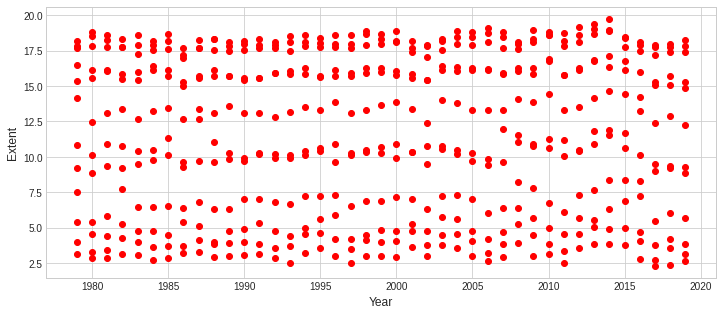

In [0]:
plt.style.use('seaborn-whitegrid')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (12, 5))

x = n_ice.Year
y = n_ice.Extent
plt.scatter(x, y, color = 'red')
plt.xlabel('Year')
plt.ylabel('Extent')

どうやら、一年の間に、かなり値が変動するらしい。

このままだと、一年の間の変化が目立ち過ぎて、全体的な変化が分かりにくい。

### 3) 一年間の範囲内での変化のパターンを可視化する

In [0]:
# seabornを使う準備
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


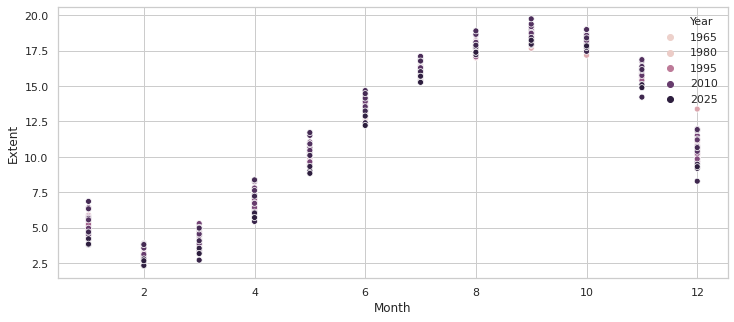

In [0]:
# seabornの散布図で、年の違いを横断して、各月ごとに面積データを可視化する。
# つまり、面積データに季節性があるかどうかを確認する。
sns.scatterplot(x="Month", y="Extent", hue="Year", data=n_ice)
plt.savefig("IceExtentByMonth.png", dpi = 300, bbox_inches = 'tight')

一年間の間で、はっきりした周期的な変化パターンがあることがわかる。

つまり、「この月は、だいたいこのぐらい値」という値があることが分かる。

### 4) 一年間の範囲内に見られる変化パターンを取り除く

In [0]:
# 各月のデータの、すべての年にわたる平均と標準偏差を求める。
grouped = n_ice.groupby('Month')
month_means = grouped.Extent.mean()
month_stds = grouped.Extent.std()
print('Means:', month_means)
print()
print('Standard deviations:',month_stds)

Means: Month
1      4.980793
2      3.062832
3      4.011036
4      6.840807
5     10.159689
6     13.369739
7     15.998330
8     17.765957
9     18.522389
10    18.130314
11    15.828975
12    10.414484
Name: Extent, dtype: float64

Standard deviations: Month
1     0.701799
2     0.423104
3     0.555361
4     0.721256
5     0.681477
6     0.588914
7     0.438749
8     0.383831
9     0.430028
10    0.402546
11    0.500676
12    0.928812
Name: Extent, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f099d5140f0>,
      dtype=object)

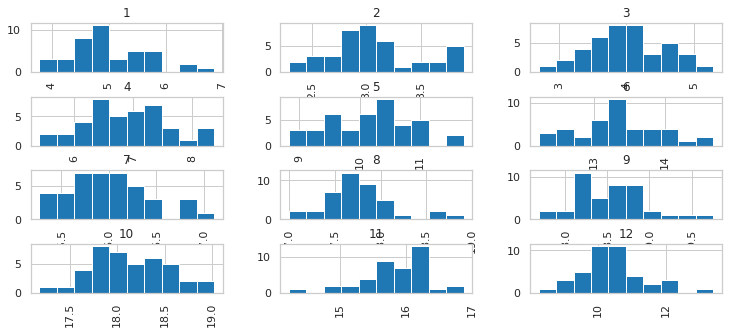

In [0]:
# 試みに、ヒストグラムを月別に描いてみる。
n_ice.Extent.hist(by=n_ice_monthly.Month)

In [0]:
# 月ごとにz値へ変換する。（よく使うデータ標準化の手法。）
for i in range(1, 13):
  idx = n_ice.Month == i
  z_values = (n_ice.loc[idx, 'Extent'] - month_means[i]) / month_stds[i]
  n_ice.loc[idx, 'Extent'] = z_values

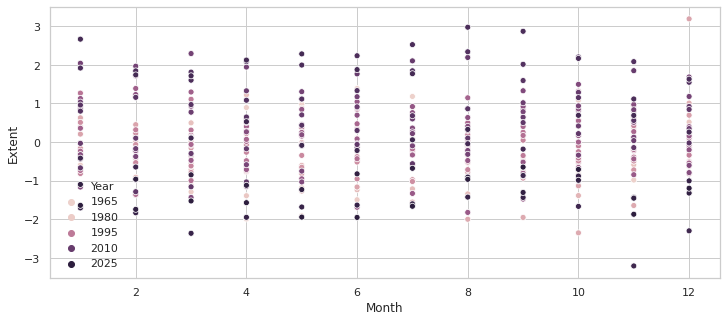

In [0]:
# z値に変換したので、改めて、年の違いを横断して、各月ごとに面積データを可視化する。
sns.scatterplot(x="Month", y="Extent", hue="Year", data=n_ice)
plt.savefig("IceExtentZscoreByMonth.png", dpi = 300, bbox_inches = 'tight')

### 5) 1979年〜2019年の全範囲での変化の様子を見る

各月の個性は、すでに消した。

その上で、1979年から2019年まで、全範囲での面積の変化の傾向を見る。

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


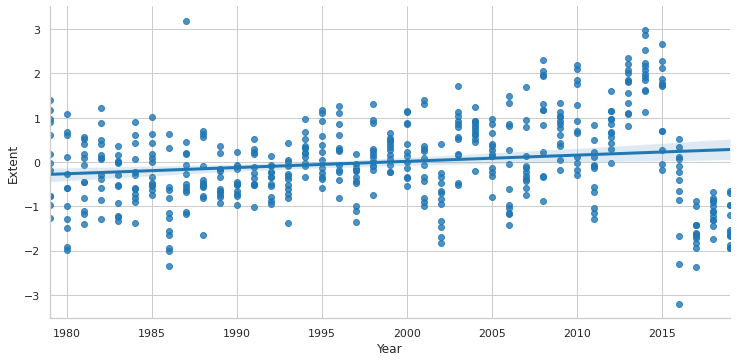

In [0]:
# seabornの単回帰のプロットを利用する。
sns.lmplot("Year", "Extent", n_ice, size = 5.2, aspect = 2);
plt.savefig("IceExtentAllMonthsByYearlmplot.png", dpi = 300, bbox_inches = 'tight')

*   直線でfittingしても、悪くなさそう。
*   そして、面積減少の傾向が見て取れる。



In [0]:
# ピアソンの相関係数と、無相関の検定のp値を求める。
import scipy.stats
scipy.stats.pearsonr(n_ice.Year.values, n_ice.Extent.values)

(0.16790343556303775, 0.00018299883603281746)



---



### 6) sklearnの線形回帰を使った分析

In [0]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

x = n_ice[['Year']]
y = n_ice[['Extent']]

reg.fit(x, y)

print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)

Coefficients: [[0.01401631]]
Intercept: [-28.01859968]


フィッティングの評価

*   mean squared error ($MSE$)
*   the coefficient of determination ($R^2$)

$R^2$は$(1 - \textbf{u}/\textbf{v})$と定義される。

$\textbf{u}$ は残差の二乗和 $\sum (\textbf{y} - \hat{\textbf{y}})^2$。（$\hat{\textbf{y}}$が回帰による予測値。）

$\textbf{v}$ は、真値の平均$\bar{\textbf{y}}$ からの個々の真値$\textbf{y}$のズレの二乗の和$\sum (\textbf{y} - \bar{\textbf{y}})^2$。

$R^2$の最も良い値は1.0。これより小さくなるほど悪くなる。

MSE: 0.9481057915376864
R^2: 0.028191563673871656


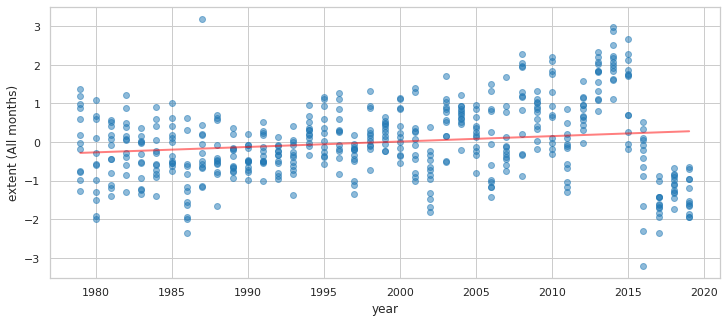

In [0]:
from sklearn import metrics

# Analysis for all months together.
x = n_ice[['Year']]
y = n_ice[['Extent']]
model = LinearRegression()
model.fit(x, y)
y_hat = model.predict(x)
plt.plot(x, y,'o', alpha = 0.5)
plt.plot(x, y_hat, 'r', alpha = 0.5)
plt.xlabel('year')
plt.ylabel('extent (All months)')
print("MSE:", metrics.mean_squared_error(y, y_hat))
print("R^2:", metrics.r2_score(y, y_hat))
plt.savefig("IceExtentLinearRegressionAllMonthsByYearPrediction.png", dpi = 300, bbox_inches = 'tight')

In [0]:
((y - y.mean()) ** 2).sum()

Extent    480.0
dtype: float64

In [0]:
((y - y_hat) ** 2).sum()

Extent    466.468049
dtype: float64

どうやら、データは長期的なnegative trendを示している、と言ってもよさそう。




---



### 7) statsmodelsの線形回帰を使った分析

こちらのほうが、統計学的な観点からの分析に向いている。


In [0]:
import statsmodels.api as sm

In [0]:
x_ = sm.add_constant(x) # 切片の項を追加

In [0]:
model = sm.OLS(y, x_)

In [0]:
results = model.fit()

In [0]:
results.params

const   -28.018600
Year      0.014016
dtype: float64

In [0]:
# statsmodelsはこのsummaryが強力。
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Extent   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     14.21
Date:                Wed, 03 Jun 2020   Prob (F-statistic):           0.000183
Time:                        03:41:41   Log-Likelihood:                -685.01
No. Observations:                 492   AIC:                             1374.
Df Residuals:                     490   BIC:                             1382.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.0186      7.432     -3.770      0.000     -42.620     -13.417
Year           0.0140      0.004      3.770      0.000       0.007       0.021
==============================================================================
Omnibus:                        2.055   Durbin-Watson:                   0.396
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                2.048
Skew:                           0.015   Prob(JB):                        0.359
Kurtosis:                       3.315   Cond. No.                     3.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 課題6

南極海氷域について、全く同様に、分析をしてみよう。

.ipynbファイルをBlackboardに提出してください。